# Simple Meander

Creates 3 transmon pockets, connected in different ways by the mean of transmission lines.

These transmission line QComponents create basic meanders to accommodate the user-defined line length.

### Preparations

The next cell enables [module automatic reload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload). Your notebook will be able to pick up code updates made to the qiskit-metal (or other) module code.

In [1]:
%reload_ext autoreload
%autoreload 2

Import key libraries and open the Metal GUI. Also we configure the notebook to enable overwriting of existing components

In [2]:
from qiskit_metal import designs
from qiskit_metal import MetalGUI, Dict

design = designs.DesignPlanar()
gui = MetalGUI(design)

# if you disable the next line, then you will need to delete a component [<component>.delete()] before recreating it
design.overwrite_enabled = True

In [3]:
from qiskit_metal.qlibrary.core import QRouteLead

Create 3 Transmon Qbits with 4 pins. This uses the same definition (options) for all 3 Qbits, but it places them in 3 different (x,y) origin points.

In [4]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

optionsQ = dict(
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads = dict(  # Qbits defined to have 4 pins
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        d = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

q1 = TransmonPocket(design, 'Q1', options = dict(pos_x='-1.5mm', pos_y='+0.0mm', **optionsQ))
q2 = TransmonPocket(design, 'Q2', options = dict(pos_x='+0.35mm', pos_y='+1.0mm', orientation = '90',**optionsQ))
q3 = TransmonPocket(design, 'Q3', options = dict(pos_x='2.0mm', pos_y='+0.0mm', **optionsQ))

gui.rebuild()
gui.autoscale()
gui.highlight_components(['Q1', 'Q2', 'Q3'])  # This is to show the pins, so we can choose what to connect

# Using CPW meanders to connect the 3 Qbits

Import the RouteMeander and inspect what options are available for you to initialize

In [5]:
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
RouteMeander.get_template_options(design)

{'pin_inputs': {'start_pin': {'component': '', 'pin': ''},
  'end_pin': {'component': '', 'pin': ''}},
 'fillet': '0',
 'lead': {'start_straight': '0mm',
  'end_straight': '0mm',
  'start_jogged_extension': '',
  'end_jogged_extension': ''},
 'total_length': '7mm',
 'chip': 'main',
 'layer': '1',
 'trace_width': 'cpw_width',
 'meander': {'spacing': '200um', 'asymmetry': '0um'},
 'snap': 'true',
 'prevent_short_edges': 'true',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False}

Let's define a dictionary with the options we want to keep global. We will then concatenate this dictionary to the ones we will use to describe the individual Qbits

In [6]:
ops=dict(fillet='90um')

Let's define the first CPW QComponent.

In [7]:
options = Dict(
    total_length= '8mm',
    hfss_wire_bonds = True,
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'Q1',
            pin= 'a'),
        end_pin=Dict(
            component= 'Q2',
            pin= 'b')),
    lead=Dict(
        start_straight='0mm',
        end_straight='0.5mm'),
    meander=Dict(
       asymmetry='-1mm'),
    **ops
)

# Below I am creating a CPW without assigning its name.
#  Therefore running this cell twice will create two CPW's instead of overwriting the previous one
#  To prevent that we add the cpw.delete() statement.
#  The try-except wrapping is needed to suppress errors during the first run of this cell
try:
    cpw.delete()
except NameError: pass

cpw = RouteMeander(design, options=options)
gui.rebuild()
gui.autoscale()

09:08AM 07s WARNING [check_lengths]: For path table, component=cpw_1, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
09:08AM 07s WARNING [check_lengths]: For path table, component=cpw_1, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
09:08AM 08s WARNING [check_lengths]: For path table, component=cpw_1, key=trace has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.
09:08AM 08s WARNING [check_lengths]: For path table, component=cpw_1, key=cut has short segments that could cause issues with fillet. Values in (1-1)  are index(es) in shapely geometry.


You might have received an expected python "warning - check_lengths" message.
This indicates that one of the CPW edges is too short to accommodate the fillet corner rounding previous defined at 90um.
Also, the CPW "start lead" does not offer enough clearance from the Qbit, causing a short between two pins.

Please take a minute to observe this behavior in the GUI

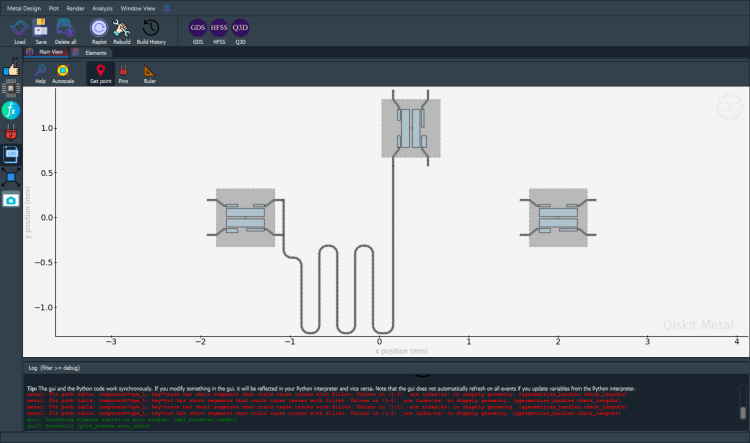

In [8]:
gui.screenshot()

You can inspect the points forming the CPW route to find the culprit edge (the warning message should have indicated the index of the offending edge)

In [9]:
cpw.get_points()

array([[-1.075     ,  0.195     ],
       [-1.07      ,  0.195     ],
       [-1.07      , -0.44916667],
       [-0.87      , -0.44916667],
       [-0.87      , -1.29421683],
       [-0.67      , -1.29421683],
       [-0.67      , -0.31578317],
       [-0.47      , -0.31578317],
       [-0.47      , -1.29421683],
       [-0.27      , -1.29421683],
       [-0.27      , -0.31578317],
       [-0.07      , -0.31578317],
       [-0.07      , -1.29421683],
       [ 0.155     , -1.29421683],
       [ 0.155     ,  0.575     ]])

Turns out that both issues can be resolved by just adding enough clearance at the start of the CPW.

In [10]:
cpw.options['lead']['start_straight']='100um'
gui.rebuild()
gui.autoscale()

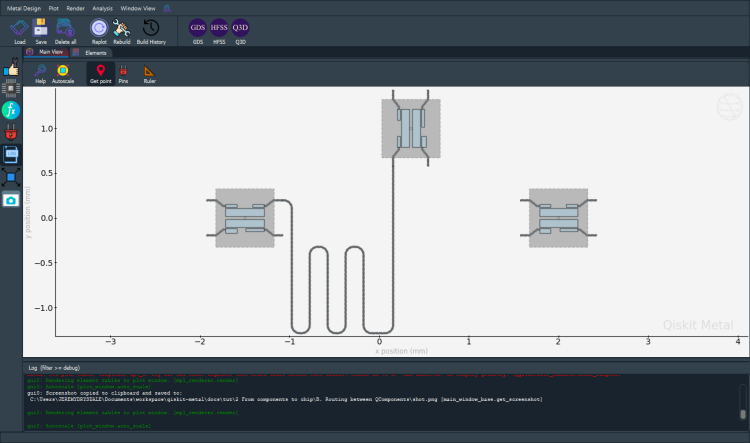

In [11]:
gui.screenshot()

Notice how the routing algorithm tries to prevent creation of edges too short to apply the fillet corner rounding. If your design requires it, you can disable this algorithm behavior for individual CPWs. For example try the cell below, and expect warning similar to the ones encountered earlier to show up

In [12]:
cpw.options['prevent_short_edges']='false'
gui.rebuild()
gui.autoscale()

09:08AM 10s WARNING [check_lengths]: For path table, component=cpw_1, key=trace has short segments that could cause issues with fillet. Values in (12-13)  are index(es) in shapely geometry.
09:08AM 10s WARNING [check_lengths]: For path table, component=cpw_1, key=cut has short segments that could cause issues with fillet. Values in (12-13)  are index(es) in shapely geometry.


You can eliminate the warning by either re-enabling the algorithm, or by changing the fillet for this specific CPW. Let's try the second approach for demonstration purposes

In [13]:
cpw.options['fillet']='65um'
gui.rebuild()
gui.autoscale()

Now let's create other 3 CPWs for practice

In [14]:
options = Dict(
    total_length= '6mm',
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'Q2',
            pin= 'd'),
        end_pin=Dict(
            component= 'Q3',
            pin= 'b')),
    lead=Dict(
        start_straight='0.1mm',
        end_straight='0.2mm'),
    meander=Dict(
       asymmetry='-0.9mm'),
    **ops
)

try:
    cpw2.delete()
except NameError: pass

cpw2 = RouteMeander(design,options=options)
gui.rebuild()
gui.autoscale()

In [15]:
options = Dict(
    total_length= '8mm',
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'Q3',
            pin= 'a'),
        end_pin=Dict(
            component= 'Q2',
            pin= 'c')),
    lead=Dict(
        start_straight='0.5mm',
        end_straight='0.1mm'),
    meander=Dict(
       asymmetry='-1mm'),
    **ops
)

try:
    cpw3.delete()
except NameError: pass

cpw3 = RouteMeander(design,options=options)
gui.rebuild()
gui.autoscale()

In [16]:
options = Dict(
    total_length= '8mm',
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'Q1',
            pin= 'b'),
        end_pin=Dict(
            component= 'Q2',
            pin= 'a')),
    lead=Dict(
        start_straight='0.5mm',
        end_straight='0.1mm'),
    meander=Dict(
       asymmetry='1mm'),
    **ops
)

try:
    cpw4.delete()
except NameError: pass

cpw4 = RouteMeander(design,options=options)
gui.rebuild()
gui.autoscale()

Let's try a more complex utilization of the leads. So far we have demonstrated `lead->start_straight` and `lead->end_straight`. We can "append" to the straight lead any number of custom jogs, which might be useful to get out of complex layout arrangements or to fine tune the meander in case of collisions with other components.

To define a jogged lead, you need an ordered sequence of turn-length pairs, which we define here as an ordered dictionary. We then apply the sequence of jogs to both the start and end leads (or you could apply it to only one them, or you can define the two leads separately with two ordered dictionaries)

In [17]:
from collections import OrderedDict
jogs = OrderedDict()
jogs[0] = ["L", '800um']
jogs[1] = ["L", '500um']
jogs[2] = ["R", '200um']
jogs[3] = ["R", '500um']

options = Dict(
    total_length= '14mm',
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'Q1',
            pin= 'd'),
        end_pin=Dict(
            component= 'Q3',
            pin= 'd')),
    lead=Dict(
        start_straight='0.1mm',
        end_straight='0.1mm',
        start_jogged_extension=jogs,
        end_jogged_extension=jogs),
    meander=Dict(
       asymmetry='-1.2mm'),
    **ops
)

try:
    cpw5.delete()
except NameError: pass

cpw5 = RouteMeander(design,options=options)
gui.rebuild()
gui.autoscale()

Here a few additional examples routing flexibility on a brand-new set of Qbits

In [18]:
q4 = TransmonPocket(design, 'Q4', options = dict(pos_x='-7.5mm', pos_y='-0.5mm', **optionsQ))
q5 = TransmonPocket(design, 'Q5', options = dict(pos_x='-5.65mm', pos_y='+0.5mm', orientation = '90',**optionsQ))
q6 = TransmonPocket(design, 'Q6', options = dict(pos_x='-4.0mm', pos_y='-0.6mm', **optionsQ))
gui.rebuild()

options = Dict(
    total_length= '3.4mm',
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'Q4',
            pin= 'a'),
        end_pin=Dict(
            component= 'Q5',
            pin= 'b')),
    lead=Dict(
        start_straight='0.5mm',
        end_straight='0.1mm'),
    meander=Dict(
       asymmetry='1mm'),
    **ops
)
try:
    cpw6.delete()
except NameError: pass
cpw6 = RouteMeander(design, options=options)
gui.rebuild()
gui.autoscale()

In [19]:
options = Dict(
    total_length= '12mm',
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'Q4',
            pin= 'd'),
        end_pin=Dict(
            component= 'Q6',
            pin= 'c')),
    lead=Dict(
        start_straight='0.1mm',
        end_straight='0.1mm'),
    meander=Dict(
       asymmetry='-1.2mm'),
    **ops
)
try:
    cpw7.delete()
except NameError: pass
cpw7 = RouteMeander(design, options=options)
gui.rebuild()
gui.autoscale()

In [20]:
options = Dict(
    total_length= '13mm',
    pin_inputs=Dict(
        start_pin=Dict(
            component= 'Q6',
            pin= 'a'),
        end_pin=Dict(
            component= 'Q4',
            pin= 'b')),
    lead=Dict(
        start_straight='0.1mm',
        end_straight='0.1mm'),
    meander=Dict(
       asymmetry='-1.7mm'),
    **ops
)
try:
    cpw8.delete()
except NameError: pass
cpw8 = RouteMeander(design, options=options)
gui.rebuild()
gui.autoscale()

In [21]:
#If you would like to close the GUI. Remove the comment.
#gui.main_window.close()